In [225]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rcParams

rcParams['font.family'] = ['Trebuchet MS']
pd.set_option("display.max_rows", None)

In [226]:
df = pd.read_excel("data_abgrid_per_analisi.xlsx")
columns_to_keep = [c for c in df.columns if not re.search(r"rank", c)]
df = df[columns_to_keep]
df.head(1)

,corso,soggetto,anno,id,contesto,lns_a,ic_a,pr_a,bt_a,cl_a,...,mutual_preferences,mutual_rejections,balance,orientation,impact,affiliation_raw,attraction_raw,affiliation,attraction,status
0,vega,ABBAMONDI MARIO,i,A,stu,"N, S, W",0.0,0.004934,0.0,0.0,...,0,0,-2,0,2,-2,0,92.25023,92.453141,underrated


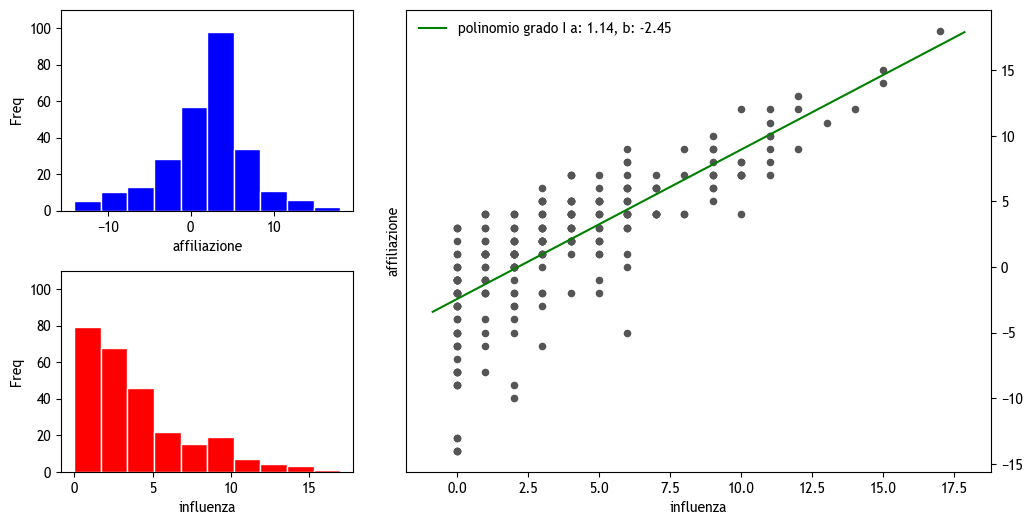

In [227]:
fig = plt.figure(figsize=(12,6))

AFF = "affiliation_raw"
INF = "attraction_raw"

gs = GridSpec(nrows=2, ncols=2, width_ratios=[1,2], hspace=.3, wspace=.12)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[:,1])

df[AFF].plot.hist(ax=ax1, color="#00F", ec='#FFF')
ax1.set_xlabel("affiliazione")

df[INF].plot.hist(ax=ax2, color="#F00", ec='#FFF')
ax2.set_xlabel("influenza")

for ax in (ax1, ax2):
    ax.set_ylabel("Freq")
    ax.set_ylim(0,110)


df.plot.scatter(x=INF, y=AFF, color="#555555",  ax=ax3)

coefficients = np.polyfit(df[INF], df[AFF], 1)
polynomial = np.poly1d(coefficients)
x_line = np.linspace(ax3.get_xlim()[0], ax3.get_xlim()[1], df[INF].shape[0])
y_line = polynomial(x_line)

ax3.plot(x_line, y_line, color='green', label=f'polinomio grado I a: {coefficients[0].round(2) }, b: {coefficients[1].round(2)}')

ax3.yaxis.tick_right()
ax3.set_xlabel("influenza")
ax3.set_ylabel("affiliazione")
ax3.legend(frameon=False);
fig.savefig("aff_inf.png", bbox_inches='tight')

In [228]:
numeric_cols = [c for c in df.select_dtypes("number").columns if c not in ["nd_a", "nd_b"]]
vega_comparison = (
    df.loc[df["corso"].str.match(r"vega")]
        .groupby(["corso", "anno"])[numeric_cols].mean().T
)

vega_comparison["diff"] = vega_comparison[('vega', 'ii')].sub(vega_comparison[('vega', 'i')])
vega_comparison.style.format(precision=2)

In [229]:
(
    df[numeric_cols].corr()
        .style
        .format(precision=2)
        .highlight_between(left=.7, right=.99, color="#00ff00")
        .highlight_between(left=-.99, right=-.7, color="#ff0000")
)

,ic_a,pr_a,bt_a,cl_a,hu_a,ic_b,pr_b,bt_b,cl_b,hu_b,received_preferences,received_rejections,given_preferences,given_rejections,mutual_preferences,mutual_rejections,balance,orientation,impact,affiliation_raw,attraction_raw,affiliation,attraction
ic_a,1.00,0.86,0.65,0.80,0.11,-0.35,-0.26,-0.21,-0.31,-0.01,0.98,-0.36,0.14,-0.09,0.60,-0.14,0.82,0.15,0.55,0.79,0.97,0.78,0.95
pr_a,0.86,1.00,0.54,0.83,0.19,-0.33,-0.24,-0.21,-0.32,0.04,0.85,-0.34,0.13,-0.08,0.60,-0.11,0.72,0.13,0.44,0.70,0.86,0.70,0.85
bt_a,0.65,0.54,1.00,0.65,-0.05,-0.26,-0.21,-0.10,-0.20,-0.02,0.67,-0.26,0.18,-0.03,0.35,-0.08,0.56,0.11,0.36,0.54,0.64,0.55,0.64
cl_a,0.80,0.83,0.65,1.00,0.18,-0.43,-0.30,-0.23,-0.35,0.01,0.80,-0.44,0.17,-0.10,0.51,-0.13,0.75,0.17,0.32,0.74,0.79,0.72,0.81
hu_a,0.11,0.19,-0.05,0.18,1.00,-0.21,-0.17,-0.14,-0.18,0.17,0.08,-0.22,0.34,0.07,0.00,-0.07,0.18,0.09,-0.13,0.19,0.06,0.20,0.05
ic_b,-0.35,-0.33,-0.26,-0.43,-0.21,1.00,0.85,0.59,0.81,-0.13,-0.35,0.99,-0.16,0.07,-0.28,0.53,-0.82,-0.14,0.56,-0.79,-0.37,-0.77,-0.39
pr_b,-0.26,-0.24,-0.21,-0.30,-0.17,0.85,1.00,0.55,0.80,-0.07,-0.28,0.85,-0.13,0.08,-0.19,0.65,-0.68,-0.14,0.51,-0.66,-0.28,-0.67,-0.30
bt_b,-0.21,-0.21,-0.10,-0.23,-0.14,0.59,0.55,1.00,0.66,0.00,-0.20,0.62,-0.08,0.41,-0.18,0.50,-0.50,-0.44,0.37,-0.57,-0.21,-0.56,-0.22
cl_b,-0.31,-0.32,-0.20,-0.35,-0.18,0.81,0.80,0.66,1.00,-0.13,-0.31,0.82,-0.20,0.10,-0.26,0.54,-0.69,-0.18,0.45,-0.68,-0.32,-0.65,-0.34
hu_b,-0.01,0.04,-0.02,0.01,0.17,-0.13,-0.07,0.00,-0.13,1.00,-0.04,-0.12,0.20,0.69,0.09,0.07,0.05,-0.58,-0.14,-0.10,-0.00,-0.11,0.01


In [230]:
(
    df[numeric_cols].mean()
)

ic_a                       0.089088
pr_a                       0.030303
bt_a                       0.046984
cl_a                       0.214077
hu_a                       0.030303
ic_b                       0.059144
pr_b                       0.030303
bt_b                       0.020567
cl_b                       0.133546
hu_b                       0.030303
received_preferences       2.840909
received_rejections        1.893939
given_preferences          2.840909
given_rejections           1.893939
mutual_preferences         0.969697
mutual_rejections          0.204545
balance                    0.946970
orientation                0.946970
impact                     4.734848
affiliation_raw      1.893939
attraction_raw        3.810606
affiliation        100.000000
attraction          100.000000
dtype: float64